# Twitter Sentiment Analysis - ChatGPT

![](https://www.kdnuggets.com/wp-content/uploads/mayo_sent_analysis_fastapi_transformers-0.jpg)

In [1]:
# Install required packages.
if (!require(rtweet)) {install.packages('rtweet'); require(rtweet)}
if (!require(magrittr)) {install.packages('magrittr'); require(magrittr)}
if (!require(data.table)) {install.packages('data.table'); require(data.table)}
if (!require(ggplot2)) {install.packages('ggplot2'); require(ggplot2)}
if (!require(graphics)) {install.packages('graphics'); require(graphics)}
if (!require(topicmodels)) {install.packages('topicmodels'); require(topicmodels)}
if (!require(quanteda)) {install.packages('quanteda'); require(quanteda)}
if (!require(quanteda.textstats)) {install.packages('quanteda.textstats'); require(quanteda.textstats)}
if (!require(quanteda.textplots)) {install.packages('quanteda.textplots'); require(quanteda.textplots)}
if (!require(stats)) {install.packages('stats'); require(stats)}
if (!require(grDevices)) {install.packages('grDevices'); require(grDevices)}
if (!require(utils)) {install.packages('utils'); require(utils)}
if (!require(methods)) {install.packages('methods'); require(methods)}
if (!require(utf8)) {install.packages('utf8'); require(utf8)}
if (!require(dplyr)) {install.packages('dplyr'); require(dplyr)}
if (!require(sentimentr)) {install.packages('sentimentr')}
if (!require(lubridate)) {install.packages('lubridate')}

Loading required package: rtweet

Loading required package: magrittr

Loading required package: data.table

Loading required package: ggplot2

Loading required package: topicmodels

Loading required package: quanteda

Package version: 3.2.4
Unicode version: 13.0
ICU version: 66.1

Parallel computing: 4 of 4 threads used.

See https://quanteda.io for tutorials and examples.

Loading required package: quanteda.textstats

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘quanteda.textstats’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘nsyllable’, ‘proxyC’


Loading required package: quanteda.textstats

Loading required package: quanteda.textplots

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘quanteda.textplots’”
Installing package into ‘/usr/local/lib

We used the following lines of code to request the tweets from Twitter's API.

In [2]:
#chatgpt1.df = search_tweets (
  #q = "chatgpt OR chatGPT OR GPT OR ChatGPT",
  #n = 10000,
  #type = "recent",
  #include_rts = FALSE,
  #geocode = NULL,
  #max_id = NULL,
  #parse = TRUE,
  #token = NULL,
  #retryonratelimit = FALSE,
  #verbose = TRUE,
  #lang = "en",
  #tweet_mode = "extended"
#)

We get 10,000 tweets that include the keywords: **chatgpt**, **chatGPT**, **GPT** or **ChatGPT**.

In [3]:
# Load the data.
data=load('../input/chatgpt/chatgpt1.RData')

In [4]:
# Create a subset with the columns that are of interest for our analysis.
data<-subset(chatgpt1.df, select=c('created_at','text','hashtags','source'))
# Take a look at the dataset.
glimpse(data)

Rows: 10,000
Columns: 4
$ created_at <dttm> 2023-01-16 21:45:27, 2023-01-16 21:45:26, 2023-01-16 21:45…
$ text       <chr> "@SandraGiffin Definitely should be focusing on your messag…
$ hashtags   <list> <"jasperai", "chatgpt">, NA, "ChatGPT", NA, "ChatGPT", NA,…
$ source     <chr> "Twitter Web App", "Twitter for iPhone", "Twitter Web App",…


In [5]:
# 20 most common hashtags.
data$hashtags %>%
  unlist %>%            
  table %>%            
  sort(decreasing = TRUE) %>% 
  head(20)

.
               ChatGPT                     AI                chatgpt 
                  1749                    558                    281 
ArtificialIntelligence                     ai                 OpenAI 
                   179                    175                    145 
               chatGPT                 openai                chatbot 
                   100                     73                     70 
       MachineLearning             technology                    GPT 
                    68                     68                     59 
                  tech artificialintelligence               chatgpt3 
                    59                     53                     45 
         OpenAIChatGPT                 Google                   GPT3 
                    39                     38                     38 
                   NLP             innovation 
                    38                     37 

The most frequently used hashtag is **chatGPT**, followed by **AI**.

We also notice that there are references to:
- chatGTP's name with different variations: '**ChatGPT**', '**chatgpt**', '**chatGPT**', '**GPT**'.
- the tech deployed: '**chatbot**', '**AI**', '**ArtificialIntelligence**', '**ai**', '**technology**', '**tech**', '**artificialintelligence**', '**MachineLearning**'.
- the family of language models that it belongs: '**chatgpt3**', '**GPT3**', '**NLP**'.
- the launching company's name: '**OpenAI**', '**openai**', '**OpenAIChatGPT**'.
- the rival company: '**Google**'.

In [6]:
# Tweets coming from bot accounts.
bots<-grep('Bot|bot|bots|Bots',data$source)
length(bots)

# Remove the tweets written by bots.
data<-data[-grep('Bot|bot|bots|Bots',data$source),]

[1] 109

In [7]:
# Get the min and max of the 'created_at' column to see the range of dates related to the tweets creation.
data$created_at <- as.Date(data$created_at)
min(data$created_at, na.rm = TRUE)
max(data$created_at, na.rm = TRUE)

[1] "2023-01-16"

[1] "2023-01-16"

## Text Manipulation

In [8]:
# Tokenize tweets.
tok_tweets = data$text %>% 
  gsub("#","", . ) %>% 
  corpus %>% 
  tokens(what="word",
         remove_numbers=TRUE,
         remove_punct=TRUE,
         remove_symbols=TRUE,
         remove_separators=TRUE,
         remove_url=TRUE)

In [9]:
# Stopwords removal.
stopwords(language = "en")[1:10]
tok_tweets = tokens_remove(tok_tweets,stopwords(language = "en"))
words.to.remove = c(stopwords("english"),'chatgpt','chatGPT','GPT','ChatGPT','#chatgpt')

[1] "i"         "me"        "my"        "myself"    "we"        "our"      
 [7] "ours"      "ourselves" "you"       "your"

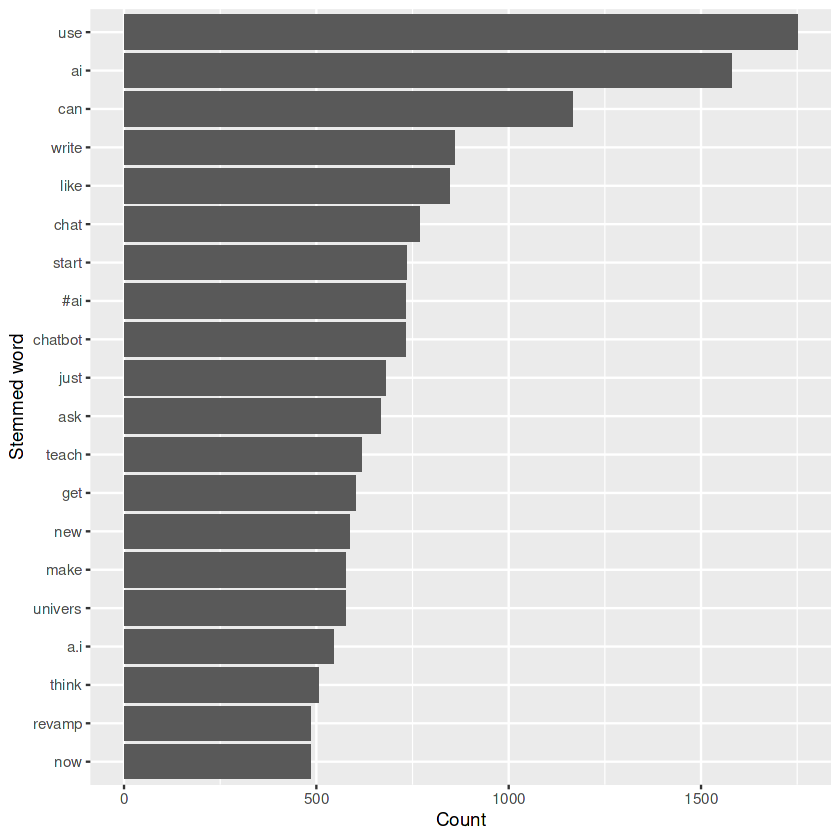

In [10]:
# Get word frequencies.
dfmat_corp_twitter = data$text %>% corpus() %>% 
  tokens( what = "word",
          remove_punct = TRUE,
          remove_url=TRUE,
          remove_symbols = TRUE) %>% 
  tokens_remove(words.to.remove) %>% 
  tokens_wordstem(language = "en") %>% 
  dfm()

# 20 most frequent words.
dfFreq = textstat_frequency(dfmat_corp_twitter) %>%
  as.data.table
ggplot(dfFreq[1:20,], aes(x=reorder(feature, -rank), y=frequency)) + 
  geom_col() +
  coord_flip() +
  labs(x = "Stemmed word", y = "Count")

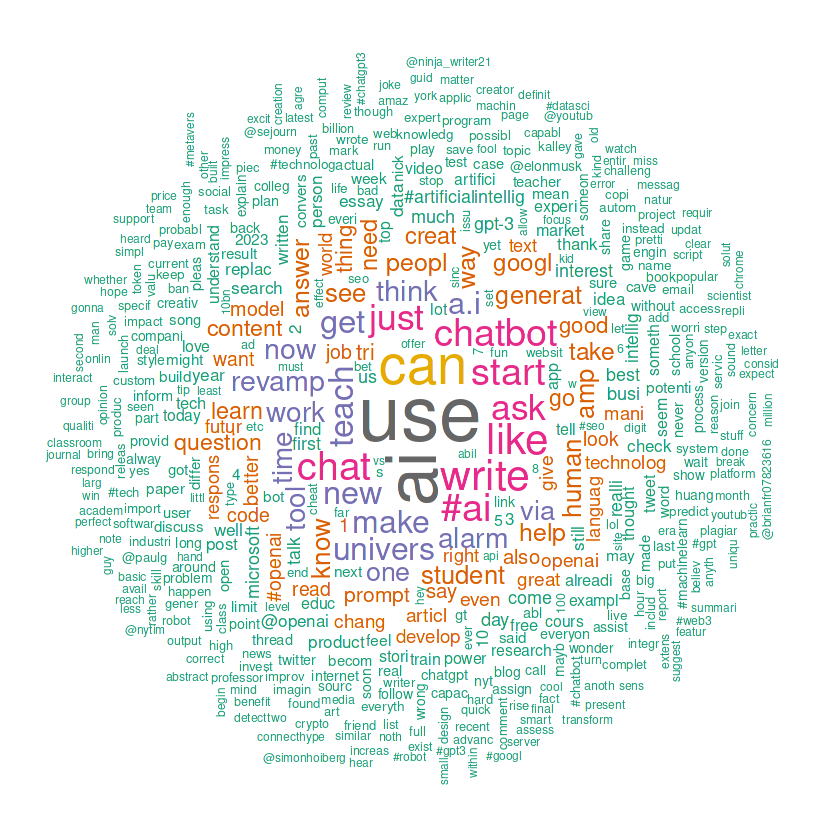

In [11]:
# Word cloud.
textplot_wordcloud(dfmat_corp_twitter, min_count = 6, random_order = FALSE,
                   rotation = .25,
                   color = RColorBrewer::brewer.pal(8, "Dark2"))

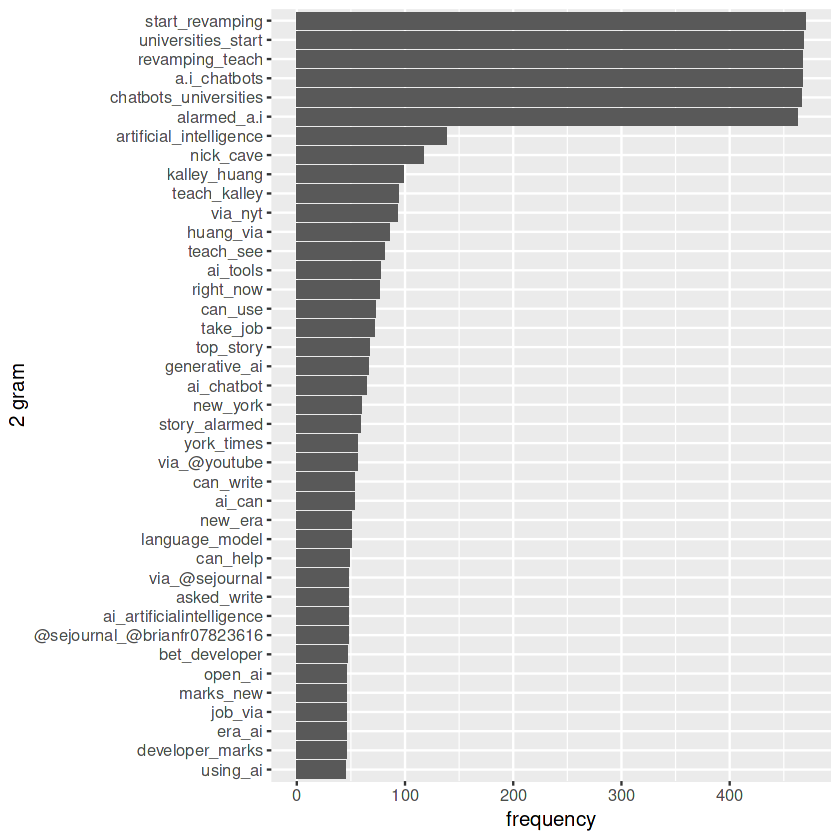

In [12]:
# 2-word frequency (2 gram)
TokensStemmed = tokens_remove(tok_tweets, words.to.remove)

dfm2 = dfm(tokens_ngrams(TokensStemmed,n=2))

dfFreq2 = textstat_frequency(dfm2)

ggplot(dfFreq2[1:40,], aes(x=reorder(feature, frequency), y=frequency)) + 
  geom_col() +
  coord_flip() +
  scale_x_discrete(name = "2 gram") +
  theme(text=element_text(size=12))

We notice that the most frequently used 2-words (frequency>150) reference:
- a new and improved form of teaching or, in general, of executing something:  '**start_revamping**', '**revamping_teach**'.
- universities and their use of chatbots: '**universities_start**', '**chatbots_universities**'.
- the technology behind chatGPT: '**a.i_chatbots**'.
- the feeling that some people might be experiencing because of the AI's applications: '**alarmed_a.i**'.

We can also notice a number of references to '**Kalley Huang**', who is actually a New York Times reporter that wrote an article on January 16th 2023 about chatGPT with the title 'Alarmed by A.I. Chatbots, Universities Start Revamping How They Teach. With the rise of the popular new chatbot ChatGPT, colleges are restructuring some courses and taking preventive measures.'.

In [13]:
# 10 most commonly used words in a tweet containing the word 'chatgpt'.
similar_wrds <- textstat_simil(dfmat_corp_twitter, 
                               margin="features",
                               method = "cosine")
similar_wrds[,"chatgpt"] %>% sort(decreasing = TRUE) %>% head(10)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


chatgpt    melancholi        devalu inconsequenti        destin 
    1.0000000     0.3674970     0.3440165     0.3440165     0.3313667 
         role          imit       authent        experi        matter 
    0.3099007     0.3024951     0.2619684     0.2279212     0.1854114

The words '**melancholi**', '**devalue**' and '**inconsequenti**' that appear closest to 'chatgpt' refer to a blog post written by Nick Cave on the same day when the tweets were scraped. The famous singer and song-writter criticized chatGPT's abilities on writing songs ispired by his own music. As he said himself, “ChatGPT’s melancholy role is that it is destined to imitate and can never have an authentic human experience, no matter how devalued and inconsequential the human experience may in time become.”.

## Sentiment Analysis

In [14]:
# Get the tweets sentiment.
sentiment_by_tweet = data$text %>% get_sentences %>% sentiment_by()
head(sentiment_by_tweet)

# Add the sentiment scores for each tweet.
setDT(data)
data = cbind(data,sentiment_by_tweet)

element_id,word_count,sd,ave_sentiment
<int>,<int>,<dbl>,<dbl>
1,45,0.1272566,0.08857315
2,20,NA,0.00000000
3,26,0.1431732,0.16248585
4,12,0.0000000,0.00000000
5,18,0.3304611,-0.25502246
6,16,NA,0.06250000


The lines of code above will add **4 new columns** to the dataset: 
1. **element_id** (adds an index to the tweets)
2. **word_count** (counts the words that they contain in the 'text' variable)
3. **sd** (the standard deviation) 
4. **ave_sentiment** (the average sentiment of the tweet)

[1] 0.07142675

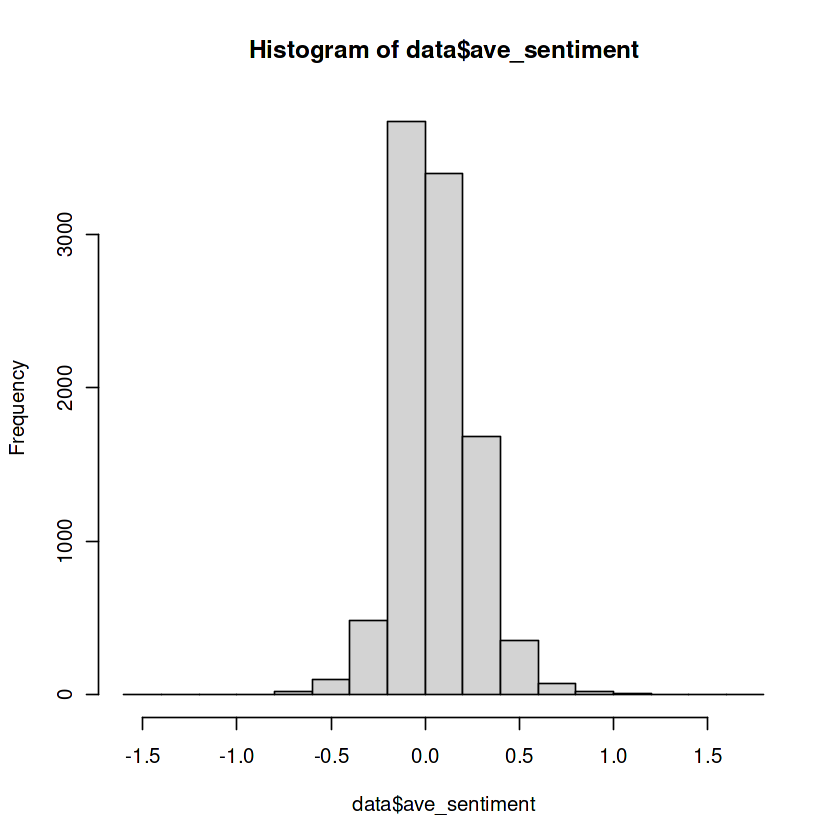

In [15]:
# Histogram of average sentiment.
hist(data$ave_sentiment)
# Mean of average sentiment.
mean(data$ave_sentiment)

The average sentiment of the tweets containing the chatGPT keywords is **positive**.

In [16]:
# 10 most negatively-charged tweets.
data[,.(text, ave_sentiment)][order(-ave_sentiment)] %>% tail(10)

text,ave_sentiment
<chr>,<dbl>
I wish I could have the same overconfidence of ChatGPT in replying with utter nonsense to questions on which I know nothing 😒 https://t.co/qzPGhkH9nj,-0.7313103
"‘it is the breathless confrontation with one’s vulnerability, one’s perilousness, one’s smallness, pitted against a sense of sudden shocking discovery’ Nick Cave on where the real art of writing songs lies and why AI is too soulless to get anywhere close https://t.co/S2jrd0IKg6",-0.7339768
ChatGPT sounds very tricky in French 😆,-0.7348469
@aeyakovenko Would have been a bad move for Google back when Microsoft could only use the OS to switch search over to Bing Would be suicide now that Microsoft can attack Google with ChatGPT,-0.7460188
"Nick Cave uses interesting words to describe a song ""in the style of Nick Cave"" written by #ChatGPT: replication as travesty, a kind of burlesque, mimicry, pastiche, bullshit, grotesque mockery",-0.7941977
"The best piece on ChatGPT does not come from your usual AI think tank crowd, but from Nick Cave https://t.co/WyBJY6CvDK",-0.8471152
#ChatGPT is having way too many sick days.,-0.9722718
"I don't know about you, but I'd be awfully excessive in my Google search before attempting chatGPT.",-0.9822693
"@hpmimanu The three Unforgivable Curses are: Avada Kedavra (Killing Curse), Imperio (Domination Curse) and Cruciatus (Torture Curse).",-1.0671568


In [17]:
# 10 most positively-charged tweets.
data[,.(text, ave_sentiment)][order(-ave_sentiment)] %>% head(10)

text,ave_sentiment
<chr>,<dbl>
"@hpmimanu I'm not sure if I'm intelligent or not, but I do think I'm capable of learning and understanding complex concepts.",1.644817
"Opportunity #3: The new AI tools like chatGPT and the upcoming GPT-4 from OpenAI will improve your Search Engine Optimization and content generation, leading to more organic traffic and increased trust and authority in your local market.",1.303333
Very funny truth especially among junior developers currently #chatgpt #ia #developers #flutter https://t.co/0DTX3ZmggQ,1.280588
"I know it’s just one person’s perspective on ChatGPT, but it’s a particularly thoughtful one (and sharp-tongued, which I love) https://t.co/WyBJY6CvDK https://t.co/SpQgKrSq0h",1.174765
"I mean, sure AI like ChatGPT is getting smarter and smarter every day, but I doubt it'll ever reach the same level of creative genius Product designers can so effortlessly deliver...😉",1.171925
"Tweet 2: ""With ChatGPT's advanced language understanding and generation capabilities, customer service interactions will become more efficient and personalized #AIrevolution #CustomerService""",1.160519
"Tweet 3: ""With ChatGPT's advanced language understanding and generation capabilities, customer service interactions will become more efficient and personalized #AIrevolution #customerservice""",1.160519
ChatGPT is very good at giving ideas and finding relevant information; it is also very good at making up information,1.133686
@AmarHujan ChatGPT is very good if you’re honest and thorough.,1.115592


In [18]:
# T-test
t.test(
  x =  data[grepl("chatgpt|chatGPT|GPT|ChatGPT",text),ave_sentiment],
  y = data[grepl("ai|AI|ArtificialIntelligence|artificialintelligence",text),ave_sentiment]
)


	Welch Two Sample t-test

data:  data[grepl("chatgpt|chatGPT|GPT|ChatGPT", text), ave_sentiment] and data[grepl("ai|AI|ArtificialIntelligence|artificialintelligence", text), ave_sentiment]
t = -3.2383, df = 6808.6, p-value = 0.001208
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.019866654 -0.004883861
sample estimates:
 mean of x  mean of y 
0.07970364 0.09207890 


We performed a Welch’s t-test between two samples; ‘chatGPT’ and ‘AI’ (including all the different variations of these words) to investigate if there is a **difference in the sentiment of users towards ChatGPT and AI**. Since the users tweeting about ChatGPD have also mentioned AI, we want to test the hypothesis that the users’ sentiment towards these two populations is equal. The hypothesis was formulated as follows:

- **Null Hypothesis**: The users’ sentiment towards chatGPT and AI is the same.
- **Alternative Hypothesis**: The users’ sentiment towards chatGPT is different than that towards AI.

According to the t-test’s results, the p-value is equal to 0.001208. Since the p-value is smaller than the significance level (0.05), we will reject the null hypothesis and we will conclude that **the difference between the sentiment is significant**.

The average sentiment towards ChatGPT is positive, as it is for AI. However, **the average sentiment towards ChatGPT appears to be less positive than for AI**. This could be due to scepticism surrounding this new technology.


In [19]:
# Frequency analysis of positive terms.
data[,.(text),] %>% 
  get_sentences() %>%              
  extract_sentiment_terms() %>%    
  .[,positive] %>%                 
  unlist %>%                       
  table  %>%                       
  sort(decreasing = TRUE) %>% 
  head(10) %>% 
  as.data.frame.table

.,Freq
<fct>,<int>
like,746
new,556
teach,541
content,348
work,335
good,323
technology,293
better,257
great,229


In [20]:
# Frequency analysis of negative terms.
data[,list(text),] %>% 
  get_sentences() %>%              
  extract_sentiment_terms() %>%   
  .[,negative] %>%                
  unlist %>%                       
  table  %>%                       
  sort(decreasing = TRUE) %>% 
  head(10) %>% 
  as.data.frame.table

.,Freq
<fct>,<int>
alarmed,471
cave,123
wrong,96
developer,81
wait,71
would be,70
bad,69
hard,68
stop,68


As far as the negative terms are concerned, we are going to perform **finetuning** to remove the words 'cave', 'developer' and 'would be', since they do not have an actual negative sentiment.

In [21]:
# Finetuning.
head(lexicon::hash_sentiment_jockers_rinker)
my_key = lexicon::hash_sentiment_jockers_rinker
my_key <- update_key(my_key, drop = c("cave", "developer", "would be"))

data[,list(text),] %>% 
  get_sentences() %>%              
  extract_sentiment_terms(polarity_dt = my_key) %>%    
  .[,negative] %>%                 
  unlist %>%                       
  table  %>%                       
  sort(decreasing = TRUE) %>% 
  head(10) %>% 
  as.data.frame.table

x,y
<chr>,<dbl>
a plus,1.00
abandon,-0.75
abandoned,-0.50
abandoner,-0.25
abandonment,-0.25
abandons,-1.00


.,Freq
<fct>,<int>
alarmed,471
wrong,96
wait,71
bad,69
hard,68
stop,68
enough,61
problem,60
plagiarism,59


**Conclusion**: Even though the sentiment analysis performed on Twitter has its limitations (since it only includes the most recent tweets; 10,000 tweets created on the 16th of January 2023), it still provides us with some useful insights:
- the technology has been made public on November 2022, however people are still highly interested about its capabilities and consequences.
- people appear to have a positive sentiment towards ChatGPT.
- their sentiment towards AI appears to be more positive, possibly due to the scepticism and criticism surrounding ChatGPT.

However, our analysis results continue to remain limited providing us only with a glimpse about the users' sentiment towards this new tool.